In [24]:
import sqlite3
import pandas as pd

# Connect to your SQLite database
conn = sqlite3.connect('/content/airlines data analysis.db')

In [17]:
query = """
SELECT flight_no, COUNT(*) AS total_flights
FROM flights
GROUP BY flight_no;

"""

# Execute the query and load the results into a DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

print(df)

    flight_no  total_flights
0      PG0001              8
1      PG0002              9
2      PG0003             17
3      PG0004             18
4      PG0005             26
..        ...            ...
705    PG0706              9
706    PG0707             61
707    PG0708             61
708    PG0709              9
709    PG0710              9

[710 rows x 2 columns]


In [3]:
query = """
WITH FlightSeats AS (
    SELECT
        f.flight_id,
        f.flight_no,
        COUNT(s.seat_no) AS total_seats
    FROM
        flights f
    JOIN
        seats s ON f.aircraft_code = s.aircraft_code
    GROUP BY
         f.flight_no , f.flight_id
),
OccupiedSeats AS (
    SELECT
        f.flight_id,
        COUNT(bp.seat_no) AS occupied_seats
    FROM
        flights f
    JOIN
        boarding_passes bp ON f.flight_id = bp.flight_id
    GROUP BY
        f.flight_id
)
SELECT
    fs.flight_id,
    fs.flight_no,
    COALESCE(os.occupied_seats, 0) AS occupied_seats,
    fs.total_seats,
    ROUND(COALESCE(os.occupied_seats, 0) * 100.0 / fs.total_seats, 2) AS occupancy_rate_percentage
FROM
    FlightSeats fs
LEFT JOIN
    OccupiedSeats os ON fs.flight_id = os.flight_id
WHERE
    ROUND(COALESCE(os.occupied_seats, 0) * 100.0 / fs.total_seats, 2) > 0
group by occupied_seats
ORDER BY
occupancy_rate_percentage
    ;
"""

df = pd.read_sql_query(query, conn)
conn.close()
print(df)

     flight_id flight_no  occupied_seats  total_seats  \
0        23534    PG0020               2           50   
1        23318    PG0016               4           50   
2         2562    PG0030               1           12   
3        23877    PG0012               5           50   
4        23863    PG0012               6           50   
..         ...       ...             ...          ...   
314        365    PG0202             166          170   
315       2354    PG0208             218          222   
316       5619    PG0174              96           97   
317      10073    PG0186             115          116   
318      10075    PG0186             116          116   

     occupancy_rate_percentage  
0                         4.00  
1                         8.00  
2                         8.33  
3                        10.00  
4                        12.00  
..                         ...  
314                      97.65  
315                      98.20  
316               

The bar graph visually highlights these occupancy trends across different
 flights.

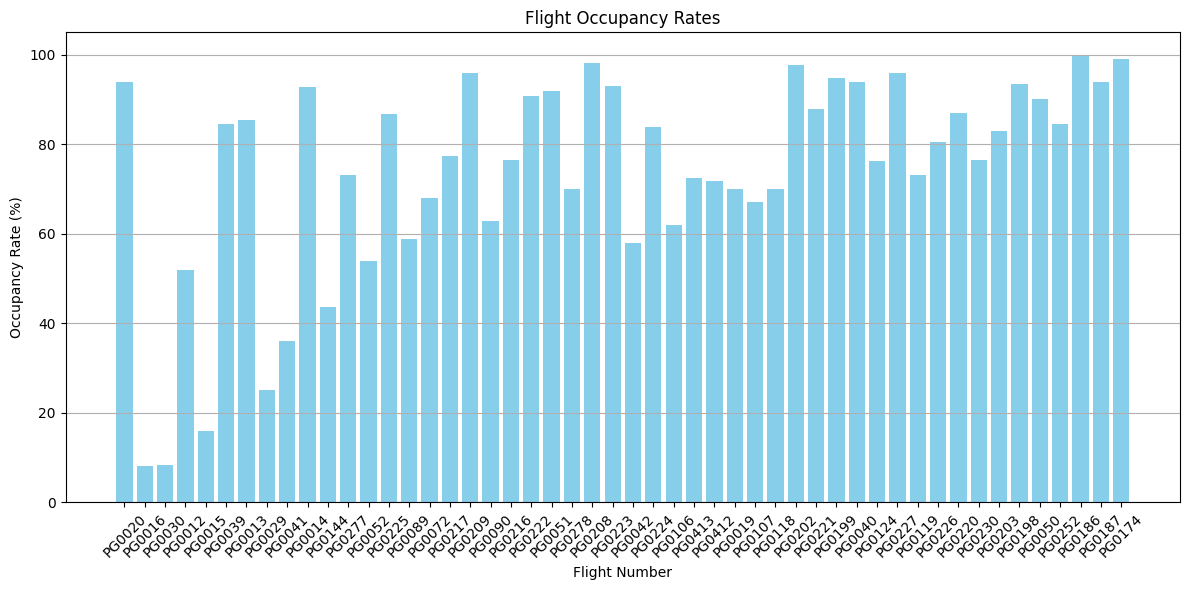

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(df['flight_no'], df['occupancy_rate_percentage'], color='skyblue')
plt.xlabel('Flight Number')
plt.ylabel('Occupancy Rate (%)')
plt.title('Flight Occupancy Rates')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
query = """
SELECT
    f.flight_no,
    SUM(tf.amount) AS total_revenue
FROM
    flights f
left JOIN
    ticket_flights tf ON f.flight_id = tf.flight_id
GROUP BY
    f.flight_no
ORDER BY
    total_revenue DESC , f.flight_no asc;
"""

df_revenue = pd.read_sql_query(query, conn)
conn.close()
print(df_revenue)


    flight_no  total_revenue
0      PG0208    753478300.0
1      PG0209    733797800.0
2      PG0222    548218900.0
3      PG0223    531503700.0
4      PG0357    507672400.0
..        ...            ...
705    PG0692            NaN
706    PG0693            NaN
707    PG0694            NaN
708    PG0701            NaN
709    PG0702            NaN

[710 rows x 2 columns]


From this two output we can observe that as the occupancy in the flight increases the revenue generated is also increases, as the many seats are vacant in some flights if we sell for medium to lower prices as per the demand, then the occupancy can be increased and can maintain the break-even point.

In [32]:
query = """
SELECT
    f.departure_airport,
    f.arrival_airport,
    COUNT(f.flight_id) AS flight_frequency

FROM
    flights f
JOIN
    airports_data a1 ON f.departure_airport = a1.airport_code
JOIN
    airports_data a2 ON f.arrival_airport = a2.airport_code
GROUP BY
    f.departure_airport,
    f.arrival_airport,
    a1.airport_name,
    a2.airport_name
ORDER BY
    flight_frequency DESC;
"""

# Execute the query and fetch the results into a DataFrame
df = pd.read_sql_query(query, conn)

# Display the DataFrame
print(df)

# Close the connection
conn.close()


    departure_airport arrival_airport  flight_frequency
0                 LED             SVO               305
1                 SVO             LED               305
2                 DME             LED               244
3                 LED             DME               244
4                 BZK             DME               183
..                ...             ...               ...
613               ROV             PES                 8
614               ROV             TOF                 8
615               SVO             DYR                 8
616               UIK             SGC                 8
617               YKS             BAX                 8

[618 rows x 3 columns]


In [35]:
import sqlite3
import pandas as pd

# Connect to SQLite database
conn = sqlite3.connect('/content/airlines data analysis.db')

# Running the flight frequency query
query = '''
SELECT
    f.departure_airport,
    f.arrival_airport,
    AVG(JULIANDAY(f.actual_departure) - JULIANDAY(f.scheduled_departure)) * 24 * 60 AS avg_departure_delay,
    AVG(JULIANDAY(f.actual_arrival) - JULIANDAY(f.scheduled_arrival)) * 24 * 60 AS avg_arrival_delay
FROM
    flights f
WHERE
    f.actual_departure IS NOT NULL
    AND f.actual_arrival IS NOT NULL
GROUP BY
    f.departure_airport, f.arrival_airport
ORDER BY
    avg_departure_delay, avg_arrival_delay;

'''

# Execute query and fetch data
flight_freq_df = pd.read_sql(query, conn)
print(flight_freq_df)

# Similarly, you can run the operational efficiency query


    departure_airport arrival_airport avg_departure_delay avg_arrival_delay
0                 AAQ             EGO                None              None
1                 AAQ             NOZ                None              None
2                 AAQ             SVO                None              None
3                 ABA             ARH                None              None
4                 ABA             DME                None              None
..                ...             ...                 ...               ...
613               YKS             BAX                None              None
614               YKS             LED                None              None
615               YKS             MJZ                None              None
616               YKS             UUD                None              None
617               YKS             UUS                None              None

[618 rows x 4 columns]


From the above output  we can observe that the operations are operating without any delays.